# ML в анализе выживаемости

In [ ]:
! pip install lifelines
! pip install pysurvival
! pip install scikit-survival
! pip install requests
! pip install --upgrade scikit-learn==1.1.2

import requests
url = 'https://gist.githubusercontent.com/sebp/82f54a5480e170fd3c303873b75a07ff/raw/912c0dba16f4f6ac03423843fdf11beb20b9fb53/export.py'
r = requests.get(url)

with open('plot_tree.py', 'w') as f:
    f.write(r.text)

from plot_tree import plot_tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines.datasets import load_kidney_transplant, load_lupus

plt.style.use('seaborn')

## Проблемы Cox Proportional Hazards Model

1. Не может моделировать нелинейное отношение риска и переменной

$$h(t) = h_0(t)*\exp(x\cdot w)$$

2. Функции риска для индивидуальных пациентов всегда пропорциональны (_proportional hazard assumption_)

Таким образом нам может быть полезно для различных подгрупп пациентов моделировать свои функции риска ($h(t)$) и соответственно выживания ($S(t)$) и куммулятивного риска ($H(t)$).

In [ ]:
X_1 = np.array([1, 1.2, 1.5, 1.75, 2, 4.75, 3.5, 4, 4.1, 4.5, 3.9, 4.5, 4.2, 4.6, 3.75])
X_2 = np.array([0.5, 0.9, 0.7, 0.6, 0.8, 0.25, 0.2, 0.1, 0.3, 0.15, 0.8, 0.7, 0.5, 0.6, 0.6])
event = np.array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0])
duration = np.array([8, 10, 9, 5, 7, 2, 2, 4, 1, 3, 19, 27, 30, 15, 24])

df = pd.DataFrame(data={'X_1': X_1, 'X_2': X_2,
                        'Death': event, 'Duration': duration})
display(df)

,X_1,X_2,Death,Duration
0,1.00,0.50,1,8
1,1.20,0.90,1,10
2,1.50,0.70,0,9
3,1.75,0.60,0,5
4,2.00,0.80,1,7
5,4.75,0.25,0,2
6,3.50,0.20,1,2
7,4.00,0.10,0,4
8,4.10,0.30,1,1
9,4.50,0.15,1,3


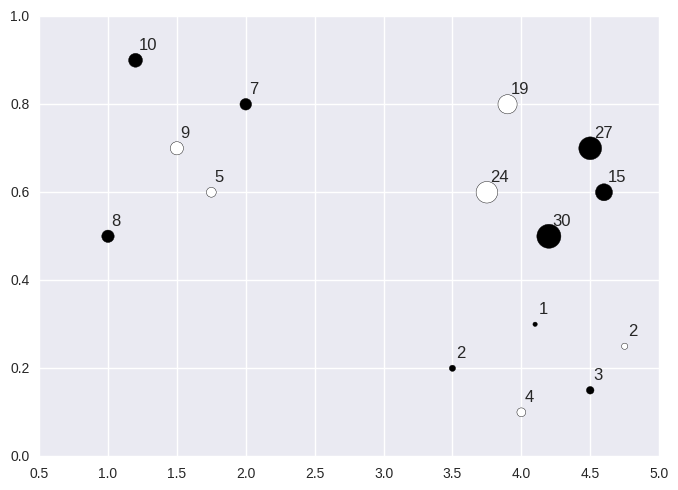

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(X_1, X_2, c=event, s=duration*10, edgecolors='black')

for i, txt in enumerate(duration):
    ax.annotate(txt, (X_1[i]+0.025, X_2[i]+0.025))

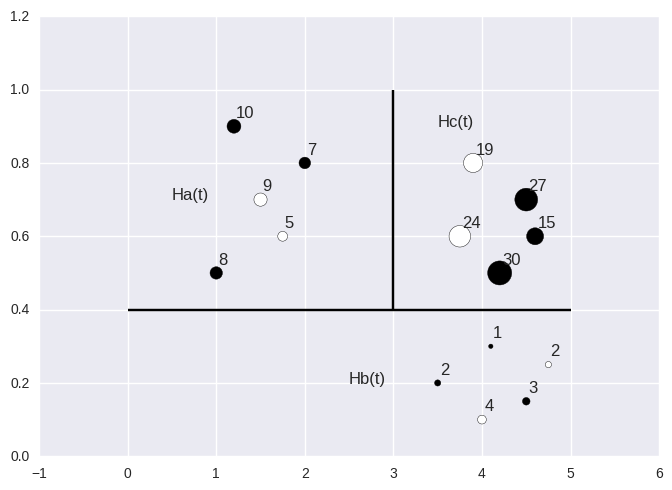

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(X_1, X_2, c=event, s=duration*10, edgecolors='black')
ax.vlines(3, 0.4, 1)
ax.hlines(0.4, 0, 5)

ax.annotate('Ha(t)', (0.5, 0.7))
ax.annotate('Hb(t)', (2.5, 0.2))
ax.annotate('Hc(t)', (3.5, 0.9))

for i, txt in enumerate(duration):
    ax.annotate(txt, (X_1[i]+0.025, X_2[i]+0.025))

## Оценка Нельсона-Аалена

Непраметрическая оценка куммулятивной функции риска.

В прошлый раз мы определяли функцию риска как:

$$h(t)=P(T=t|T\geq t)$$

Соответственно, куммулятивную функцию риска можно оценить как:

$$H(t) = \sum_{i=0}^t h(i) = \sum_{i=0}^t \frac{d_i}{n_i}$$

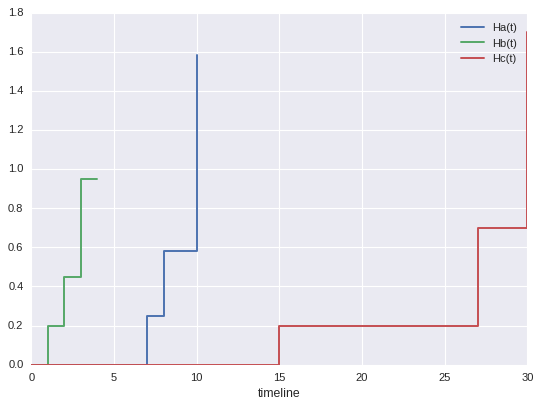

In [ ]:
naf = lifelines.NelsonAalenFitter()

naf.fit(duration[:5], event[:5])
naf.plot(ci_show=False, label='Ha(t)');

naf.fit(duration[5:10], event[5:10], label='Hb(t)')
naf.plot(ci_show=False);

naf.fit(duration[10:15], event[10:15], label='Hc(t)')
naf.plot(ci_show=False);

## Survival tree

По сути мы сейчас построили дерево выживаемости. Для более формального его описания нам нужно понять, по каким критериям будут разделяться узлы дерева.

Для разбиения используется __логранговый критерий__, выбирается тот порог разбиения, который дает наилучший p-value

In [ ]:
from sksurv.tree import SurvivalTree
from sksurv.datasets import get_x_y

In [ ]:
X, y = get_x_y(df, ['Death', 'Duration'], pos_label=1)

In [ ]:
display(X)
print(y)

,X_1,X_2
0,1.00,0.50
1,1.20,0.90
2,1.50,0.70
3,1.75,0.60
4,2.00,0.80
5,4.75,0.25
6,3.50,0.20
7,4.00,0.10
8,4.10,0.30
9,4.50,0.15


[( True,  8.) ( True, 10.) (False,  9.) (False,  5.) ( True,  7.)
 (False,  2.) ( True,  2.) (False,  4.) ( True,  1.) ( True,  3.)
 (False, 19.) ( True, 27.) ( True, 30.) ( True, 15.) (False, 24.)]


In [ ]:
estimator = SurvivalTree().fit(X, y)

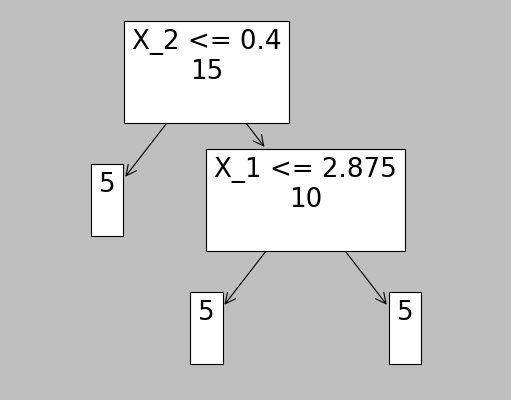

In [ ]:
plt.style.use('classic')
plot_tree(estimator, feature_names=X.columns, impurity=False, label="none");

## Переход к Random Survival Forest

1. Взять N бутстрэп выборок (с возвращением). В среднем каждая такая выборка будет включать 63% наблюдений, оставшиеся называются out-of-bag (OOB) наблюдения.

2. На каждой бутстрэп выборке строится дерево выживания. Каждый узел разбивается  на основании случайно выбранных признаков заданного количества Р (метод случайных подпространств). Лучшее разбиение максимизирует различие между дочерними узлами.

3. Предсказание функции выживания для объекта является усреднением предсказания по всем деревьям в ансамбле для всех временных точек. Предсказание в листе дерева строится как оценка Каплана-Мейера, построенная по данным, попавшим в соответствующий лист

In [ ]:
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual

In [ ]:
sim = SimulationModel( survival_distribution = 'Log-Normal',
                       risk_type = 'square',
                       censored_parameter = 1,
                       alpha = 2)

N = 500
dataset = sim.generate_data(num_samples = N, num_features=2)

dataset.head()

Number of data-points: 500 - Number of events: 105.0


/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:219: RuntimeWarning: divide by zero encountered in log
  arg_normal = (np.log(t) - np.log(_lambda))/self.beta
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:220: RuntimeWarning: divide by zero encountered in true_divide
  numerator   =  (1./(t*self.beta))*scipy.stats.norm.pdf( arg_normal )
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:220: RuntimeWarning: invalid value encountered in multiply
  numerator   =  (1./(t*self.beta))*scipy.stats.norm.pdf( arg_normal )
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:252: RuntimeWarning: divide by zero encountered in log
  arg_cdf = (np.log(t) - np.log(_lambda))/self.beta


,x_1,x_2,time,event
0,0.104197,5.791120,0.596707,1.0
1,0.007295,5.361097,0.644614,0.0
2,0.033875,4.754071,0.208550,1.0
3,0.289246,5.351532,0.140021,0.0
4,0.231614,4.442073,0.000000,0.0


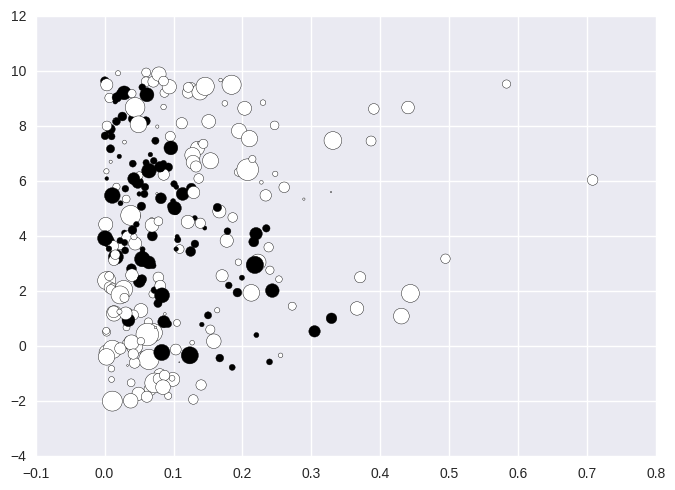

In [ ]:
plt.style.use('seaborn')

fig, ax = plt.subplots(dpi=100)
ax.scatter(dataset.x_1, dataset.x_2, c=dataset.event, s=dataset.time*20, edgecolors='black');

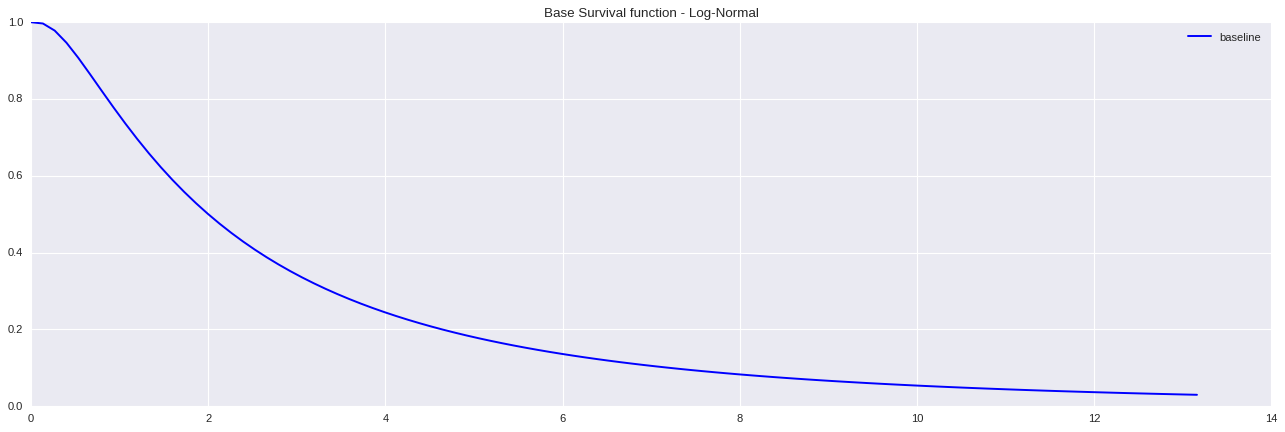

In [ ]:
from pysurvival.utils.display import display_baseline_simulations

display_baseline_simulations(sim, figure_size=(20, 6))

In [ ]:
features = sim.features

index_train, index_test = train_test_split(range(N), test_size = 0.2)
data_train = dataset.loc[index_train]
data_test  = dataset.loc[index_test]

X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values

In [ ]:
coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.5)

c_index = concordance_index(coxph, X_test, T_test, E_test)
print(f'C-index: {c_index:.2f}')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 610.850 - ||grad||^2 = 373.54720
 * Iteration #2 - Loss = 399.659 - ||grad||^2 = 46.61199
 * Iteration #3 - Loss = 389.640 - ||grad||^2 = 24.33324
 * Iteration #4 - Loss = 386.710 - ||grad||^2 = 12.91179
 * Iteration #5 - Loss = 385.772 - ||grad||^2 = 6.76450
 * Iteration #6 - Loss = 385.486 - ||grad||^2 = 3.48618
 * Iteration #7 - Loss = 385.405 - ||grad||^2 = 1.77388
 * Iteration #8 - Loss = 385.383 - ||grad||^2 = 0.89538
 * Iteration #9 - Loss = 385.377 - ||grad||^2 = 0.44990
 * Iteration #10 - Loss = 385.376 - ||grad||^2 = 0.22552
 * Iteration #11 - Loss = 385.375 - ||grad||^2 = 0.11290
 * Iteration #12 - Loss = 385.375 - ||grad||^2 = 0.05649
 * Iteration #13 - Loss = 385.375 - ||grad||^2 = 0.02825
 * Iteration #14 - Loss = 385.375 - ||grad||^2 = 0.01413
 * Iteration #15 - Loss = 385.375 - ||grad||^2 = 0.00706
 * Iteration #16 - Loss = 385.375 - ||grad||^2 = 0.00353
 * Iteration #17 - Loss = 385.375 - ||grad||^2 = 0.00

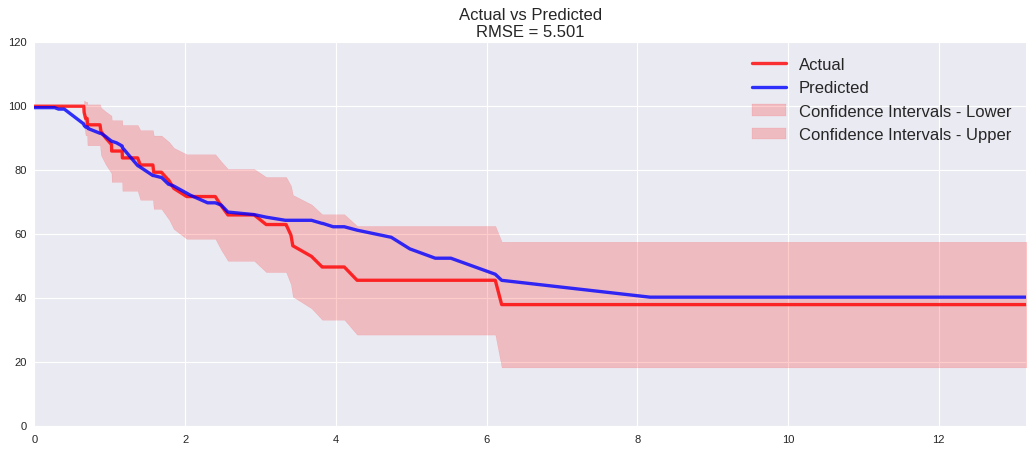

In [ ]:
results = compare_to_actual(coxph, X_test, T_test, E_test,
                            is_at_risk=True,  figure_size=(16, 6),
                            metrics='rmse')

In [ ]:
rsf = RandomSurvivalForestModel(num_trees=1000)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

c_index = concordance_index(rsf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.74


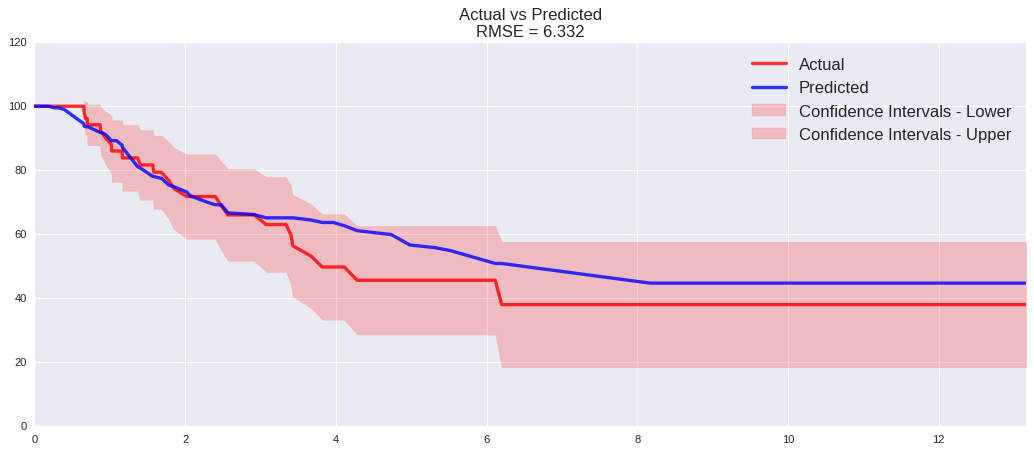

In [ ]:
results = compare_to_actual(rsf, X_test, T_test, E_test,
                            is_at_risk=True,  figure_size=(16, 6),
                            metrics='rmse')

/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:219: RuntimeWarning: divide by zero encountered in log
  arg_normal = (np.log(t) - np.log(_lambda))/self.beta
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:220: RuntimeWarning: divide by zero encountered in true_divide
  numerator   =  (1./(t*self.beta))*scipy.stats.norm.pdf( arg_normal )
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:220: RuntimeWarning: invalid value encountered in multiply
  numerator   =  (1./(t*self.beta))*scipy.stats.norm.pdf( arg_normal )
/usr/local/lib/python3.8/dist-packages/pysurvival/models/simulations.py:252: RuntimeWarning: divide by zero encountered in log
  arg_cdf = (np.log(t) - np.log(_lambda))/self.beta


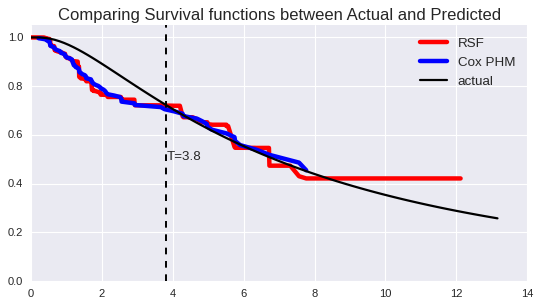

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

choices = np.argwhere((E_test==1.)&(T_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]

t = T_test[k]

rsf_pred = rsf.predict_survival(X_test.values[k, :]).flatten()
cox_pred = coxph.predict_survival(X_test.values[k, :]).flatten()
actual = sim.predict_survival(X_test.values[k, :]).flatten()

plt.plot(rsf.times, rsf_pred, color = 'red', label='RSF', lw=4)
plt.plot(coxph.times, cox_pred, color = 'blue', label='Cox PHM', lw=4)
plt.plot(sim.times, actual, color = 'black', label='actual', lw=2)

plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)

title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

Анализ важности признаков проводится с помощью пермутации признаков. Случайно перемешиваем признаки объектов OOB, пропускаем их по деревьям и считаем OOB ошибку для предсказания.

In [ ]:
rsf.variable_importance_table

,feature,importance,pct_importance
0,x_2,74.712121,0.627033
1,x_1,44.439731,0.372967


# Задание

In [ ]:
lupus = load_lupus()
lupus.head()

,dead,is_male,is_white,age_at_diagnosis,time_elapsed_between_estimated_onset_and_diagnosis_(months),year_month_of_diagnosis,year_month_of_last_observation,time_between_diagnosis_and_last_observation_(years)
id,,,,,,,,
1,False,False,False,26.0,47,1949-02,1949-11,0.747449
2,True,False,False,28.0,33,1949-03,1949-04,0.084875
3,False,False,False,35.0,65,1949-03,1953-12,4.753007
4,True,False,True,21.0,29,1949-03,1952-06,3.252634
5,True,False,True,35.0,300,1949-03,1953-09,4.503857


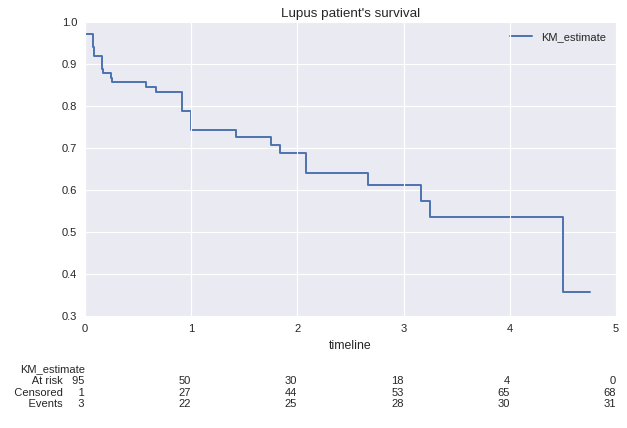

In [ ]:
durations = lupus['time_between_diagnosis_and_last_observation_(years)'].values
events = lupus['dead'].values

kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations, events)

kmf.plot_survival_function(show_censors=False, ci_show=False, at_risk_counts=True)
plt.title("Lupus patient's survival");

Построить прогностические модели на основе Cox PH и RSF, оценить важность признаков, сравнить с отложенной выборкой